In [1]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.use('TkAgg')
from pathlib import Path
import warnings, os
warnings.filterwarnings("ignore")
from glob import glob
from dea_tools.temporal import temporal_statistics, xr_phenology
from dea_tools.spatial import xr_rasterize
from utils import calculate_indices, open_ncs
import hvplot.pandas
import hvplot.xarray
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
import datetime as dt
%matplotlib inline

#### Functions

In [29]:
# gap-filling, smoothening and save
def treat_save(vis, vi, days, window, folderout, save = True):
    vis_f1 = vis[vi].interpolate_na( dim = 'time' , 
                                method =  'pchip', # pchip , spline
                                max_gap = np.timedelta64( days , 'D' )
                                ).rolling(time=window).mean(skipna=True)
    
    if save == True:
        Path(f'{folderout}').mkdir( parents = True, exist_ok = True)

        try:
            vis_f1.to_netcdf(f'{folderout}/{vi}_mgap_{days}_w_{window}_v2.nc')
        except:
            os.system(f'rm {folderout}/{vi}_mgap_{days}_w_{window}_v2.nc')
            vis_f1.to_netcdf(f'{folderout}/{vi}_mgap_{days}_w_{window}_v2.nc')
    return vis_f1


# PLOT Phenology - interactive
def plot_phenology( pheno, year, metric, farm, parcels = 'None'):

    da = pheno[metric].sel(time=pheno.time.dt.year == int(year)).squeeze()
    
    if metric in ['vSOS', 'vPOS', 'vEOS', 'AOS', 'Trough', 'LOS']:
        cmap = 'RdYlGn'
    if metric in ['SOS', 'POS', 'EOS']:
        cmap = 'bwr'
    if metric in ['ROG' , 'ROS']:
        cmap = 'magma'
    
    plotao = da.hvplot.quadmesh(x = 'longitude' , y = 'latitude', 
                geo=True, cmap=cmap, robust = True,  height = 600, rasterize = True,
                width = 800) * farm.hvplot(geo=True, line_width = 4, line_color = 'black', color='none') * parcels.hvplot(geo=True,  line_width = 1.5, 
                                                line_color = 'blue',  color='none')
    plotao.opts(opts.Overlay(title=f'{metric} for {year}'))
    # if parcels == 'None':
    #     plotao = da.hvplot.quadmesh(x = 'longitude' , y = 'latitude', 
    #                 geo=True, cmap=cmap, robust = True,  height = 400, 
    #                 width = 600) * farm.hvplot(geo=True, line_width = 3, line_color = 'black', color='none') 
    #     plotao.opts(opts.Overlay(title=pheno))
    
    
    return plotao




### define study area

In [2]:
# available areas
farms = {'fzsavana' : {'farmgroupid' : 'a5b9ae81-434a-4224-a81a-3c0ba44102b8', 
                          'file' : '/mnt/geodata/Clientes/0FARMS/FabioRicardi-Barreiras_BA/vetorial/CARs-Fazenda_Savana.gpkg',
                          'parcels' : 'talhoesfarm'},
            'embrapasanca' : {'farmgroupid' : 'fd9239de-65ae-4d0f-a1cf-9c0fd5ac9131', 
                          'file' : '/mnt/geodata/Clientes/Embrapa_SaoCarlos/fazenda_embrapa.gpkg',
                          'parcels' : 'talhoes'},
            'mavi' : {'farmgroupid' : '9a151331-1b50-4804-b416-c217d45d6ac6', 
                          'file' : '/mnt/geodata/Clientes/Mavi/limites_formosa_do_rio_preto.gpkg',
                          'parcels' : 'talhoes'}
                          }

mission = 'Landsat'

In [3]:
# choose a farm
fazenda = 'mavi'

farm = gpd.read_file(farms[fazenda]['file'])
parcels = gpd.read_file(farms[fazenda]['file'], layer = farms[fazenda]['parcels'])
foldernc = f'/mnt/geodata/Clientes/0FARMS/{farms[fazenda]["farmgroupid"]}/'
folderout = f'{foldernc}/results/'

In [4]:
# Load the data
ds = open_ncs(foldernc, mission)
ds1 = ds.resample(time='W').max(skipna=True)
del ds
ds1.dims


FrozenMappingWarningOnValuesAccess({'time': 70, 'latitude': 199, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 66, 'latitude': 198, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 71, 'latitude': 198, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 74, 'latitude': 199, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 69, 'latitude': 199, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 69, 'latitude': 199, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 73, 'latitude': 199, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 68, 'latitude': 198, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 102, 'latitude': 199, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 126, 'latitude': 199, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 168, 'latitude': 198, 'longitude': 332})


FrozenMappingWarningOnValuesAccess({'longitude': 332, 'latitude': 199, 'time': 578})

In [5]:
vi = 'LAI'
vis = calculate_indices( ds1 , index = [vi], drop = True, collection = mission)
#vis['kNDVI'] = xr.where(vis['kNDVI'] > 0.4, np.nan, vis['kNDVI'])
# vis['NDVI'] = xr.where((vis['NDVI'] > 0.74) | (vis['NDVI'] < -0.05), np.nan, vis['NDVI'])
vis[vi] = xr.where((vis[vi] > 7.4) | (vis[vi] < 0), np.nan, vis[vi])

del ds1


Dropping bands {'swir16', 'T', 'nir08', 'qa_pixel', 'red', 'blue'}


### filtering, gap-filling, smoothening,
all that is need to have a nice dataset for **phenology** 

- I've tested smoothening window and 3 and 5 worked well. 

In [8]:
vis_f1 = treat_save(vis = vis, vi = 'LAI', days = 90, window = 7, folderout = folderout, save = True)

### Phenology
The metrics:

            SOS = Date of start of season
            POS = Date of peak of season
            EOS = Date of end of season
            vSOS = Value at start of season
            vPOS = Value at peak of season
            vEOS = Value at end of season
            Trough = Minimum value of season
            LOS = Length of season (Days)
            AOS = Amplitude of season (in value units)
            ROG = Rate of greening
            ROS = Rate of senescence

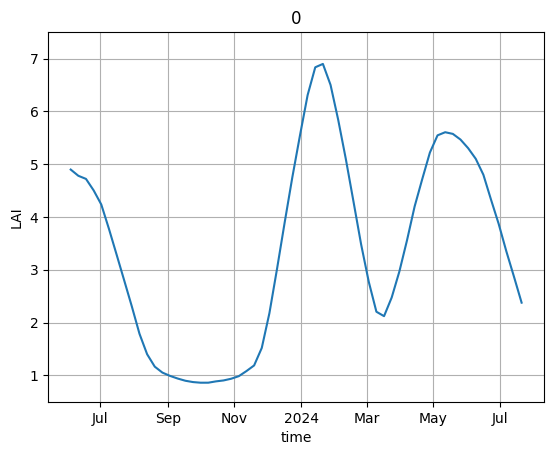

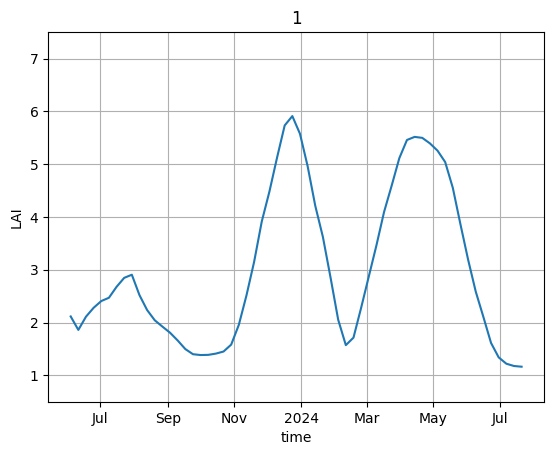

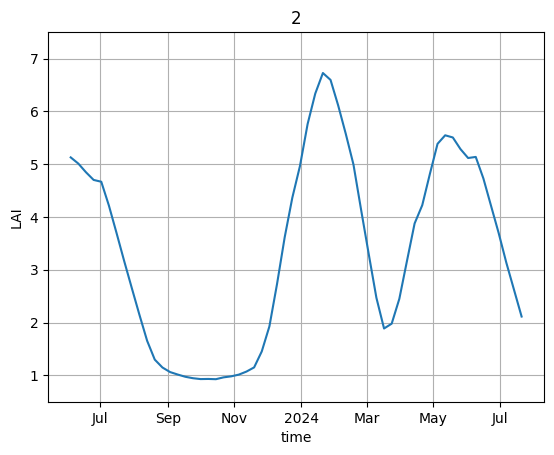

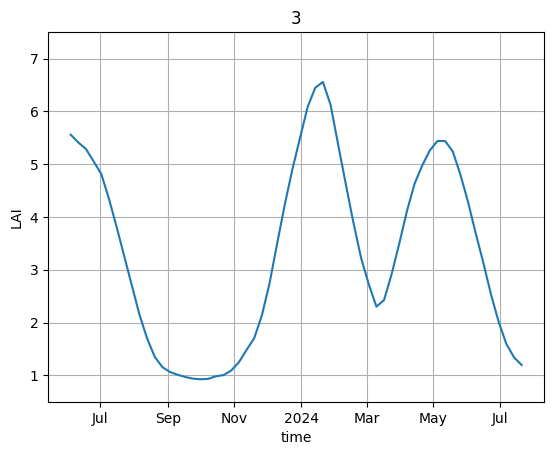

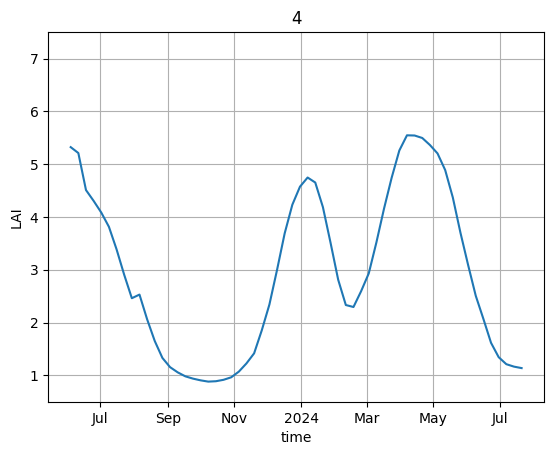

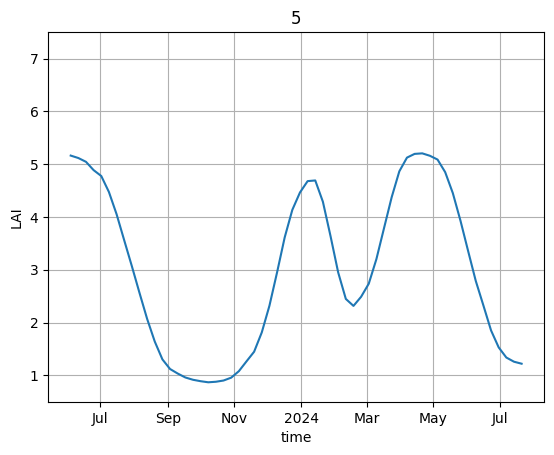

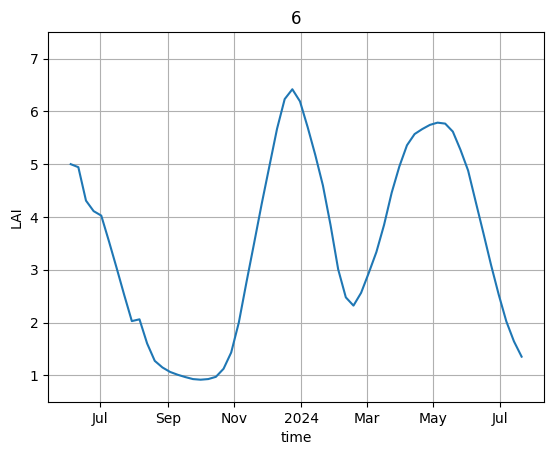

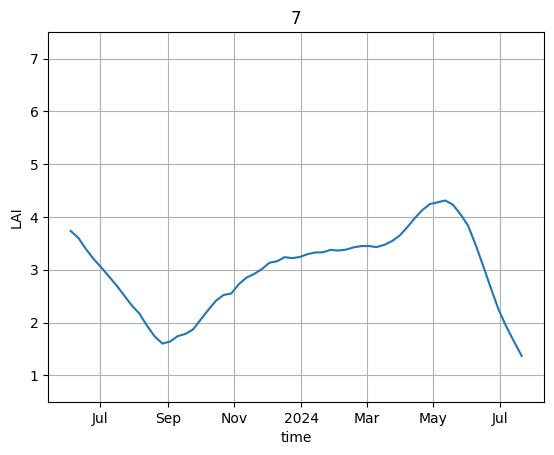

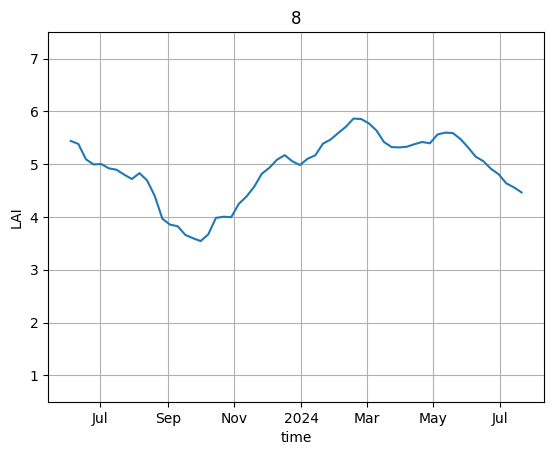

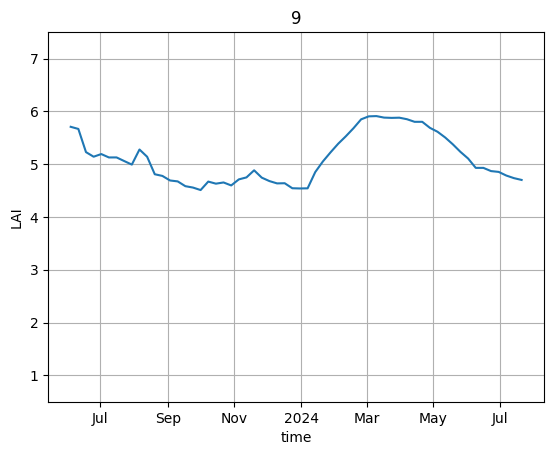

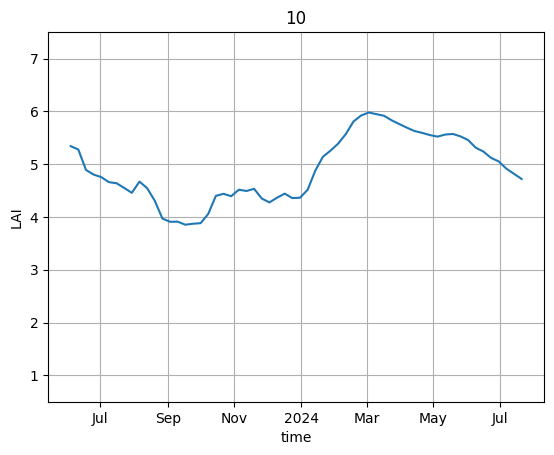

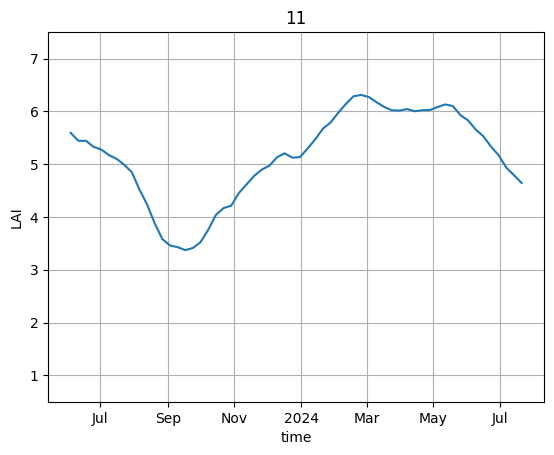

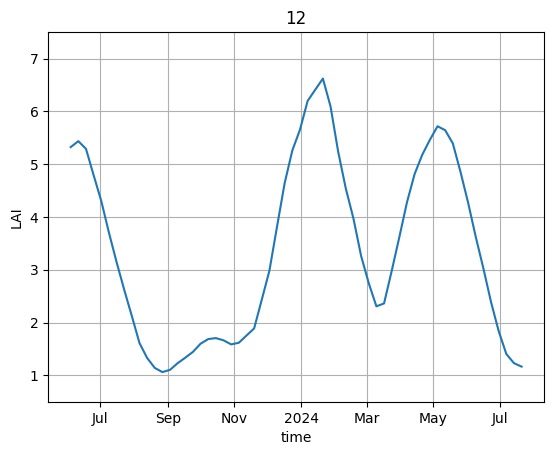

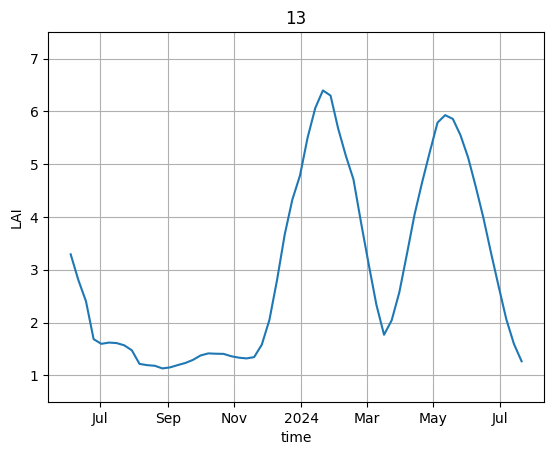

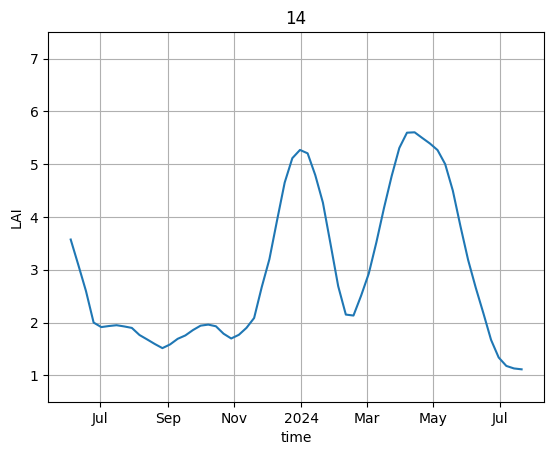

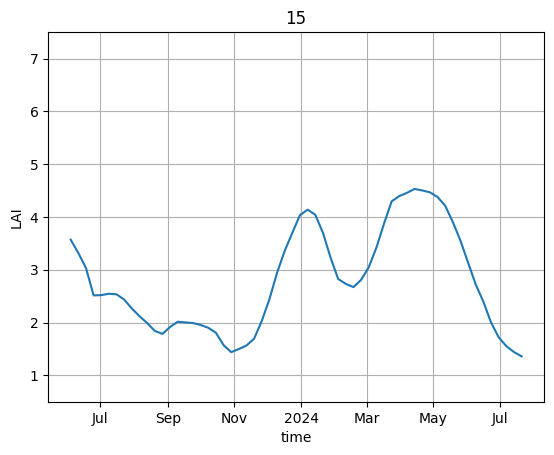

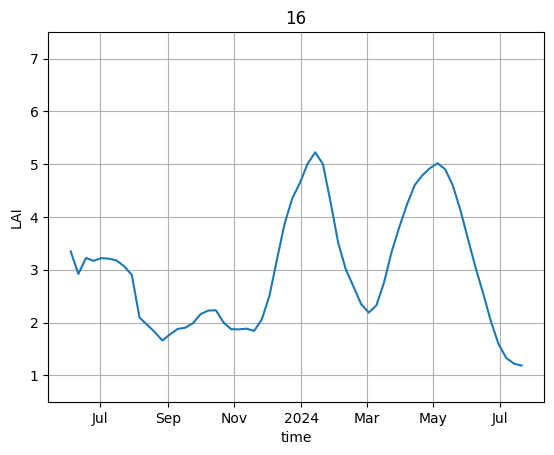

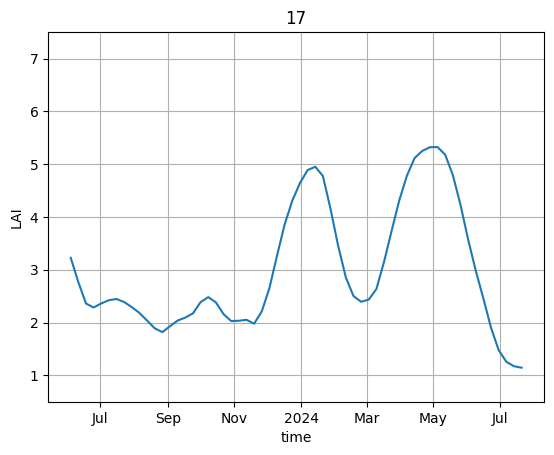

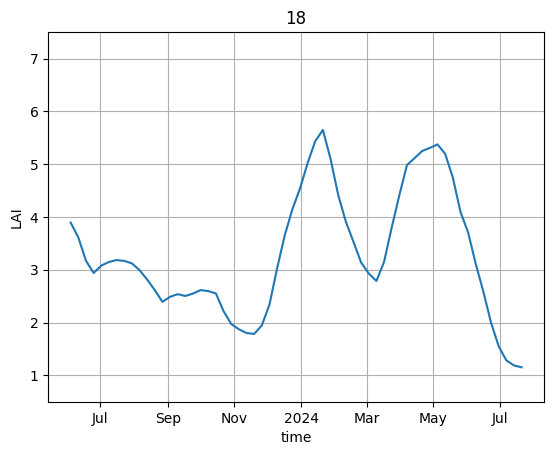

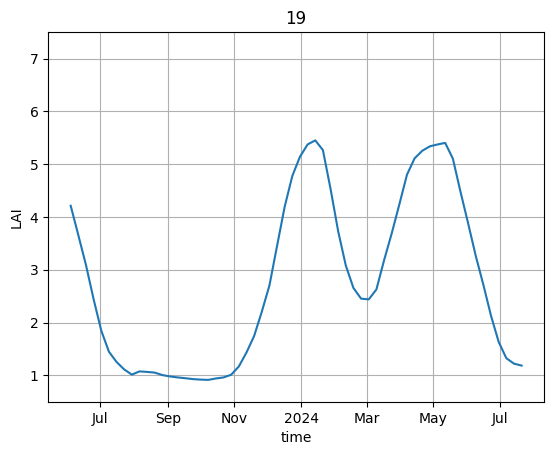

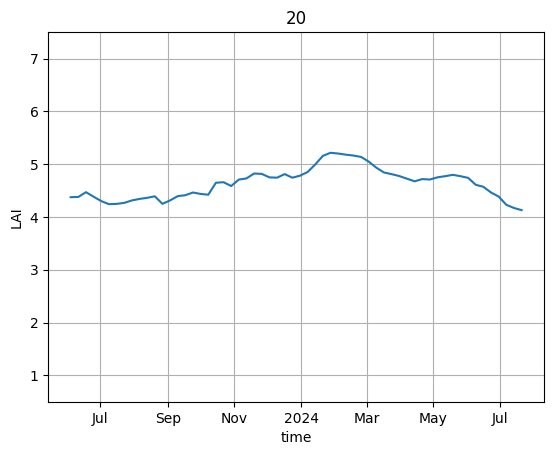

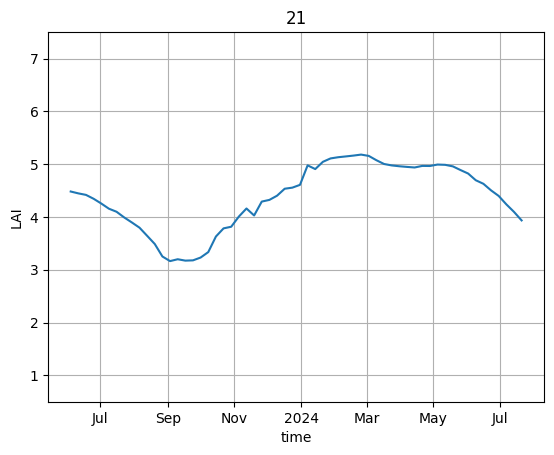

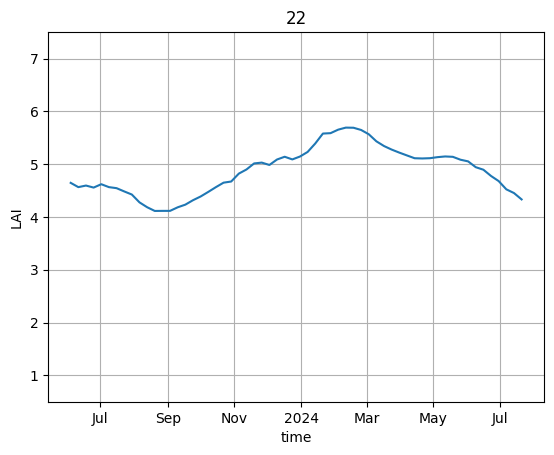

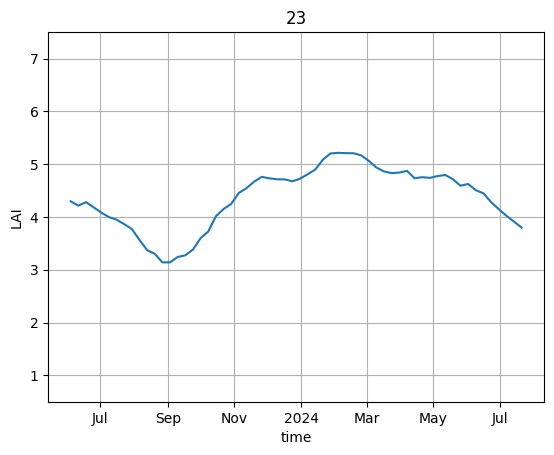

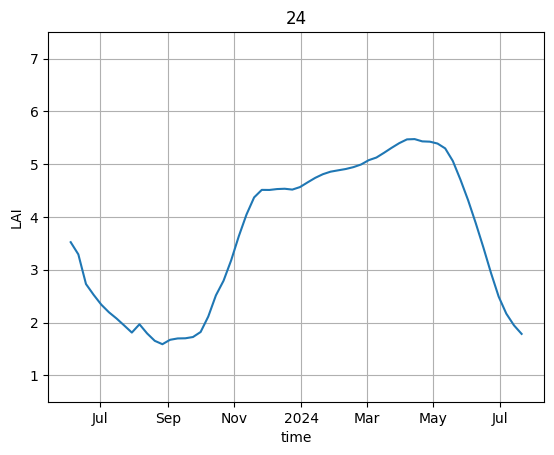

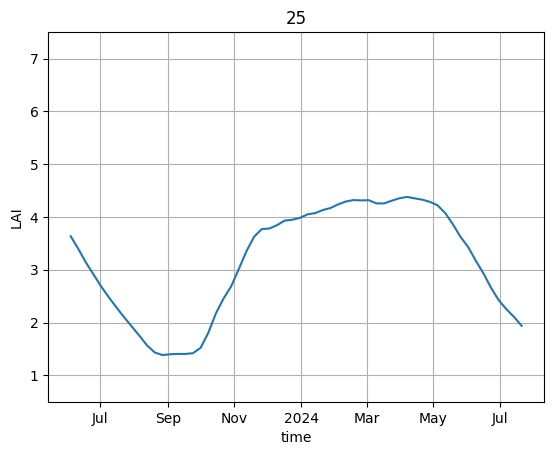

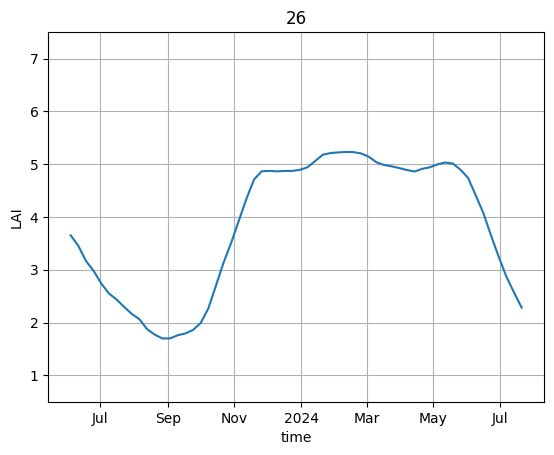

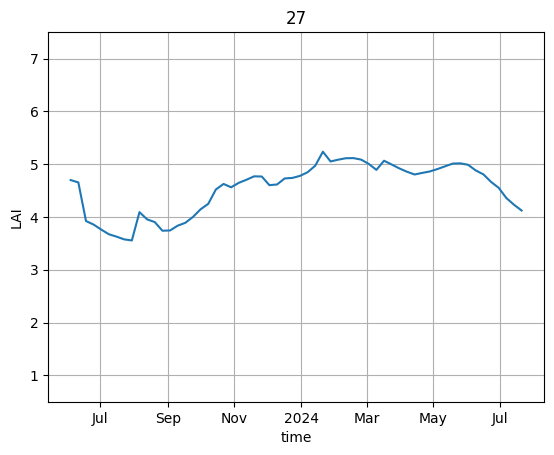

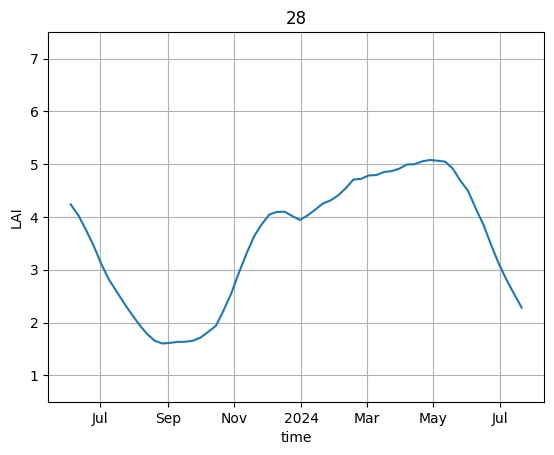

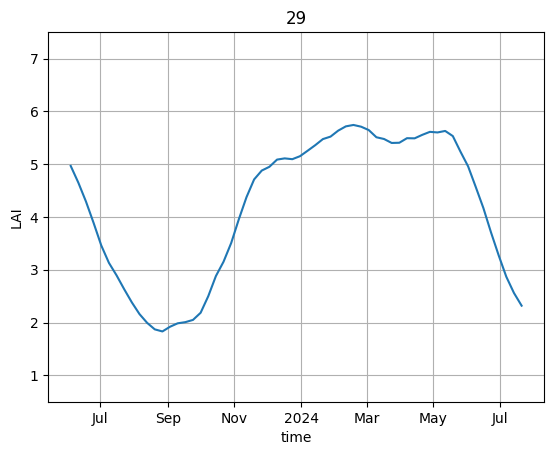

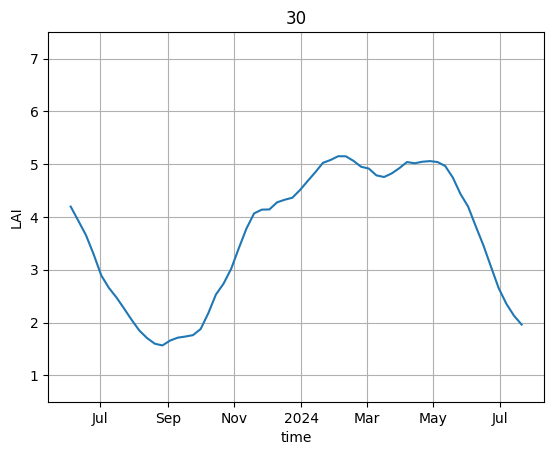

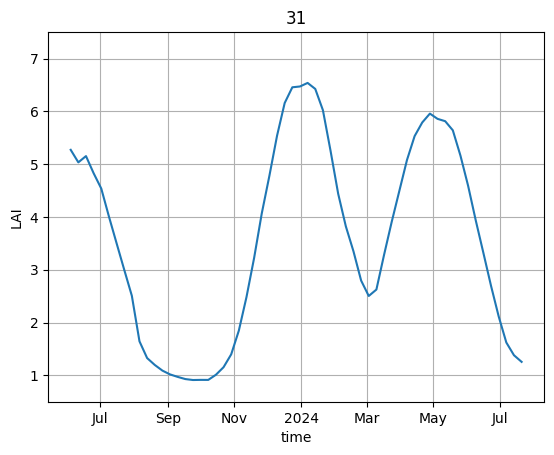

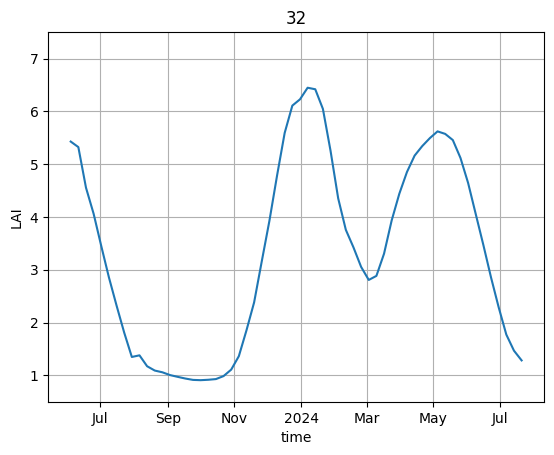

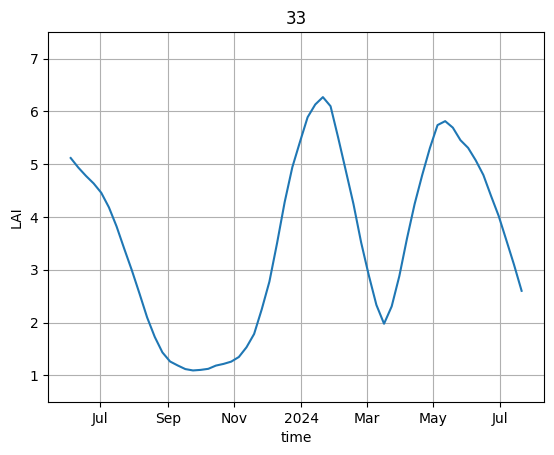

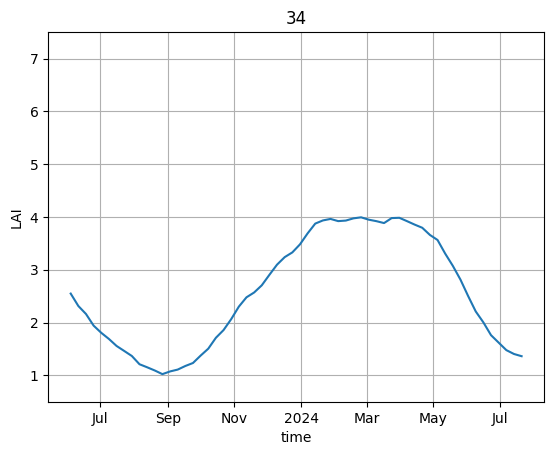

In [20]:
# Parcels quick check
datacheck = False
col = None
minmax = (0.5 , 7.5)
di, df = '2023-06','2024-07'

if datacheck:
    for i in range(len(parcels)):
        x,y = parcels.centroid[i].x , parcels.centroid[i].y
        if col == None:
            vis_f1.sel(time=slice(di,df)).sel(longitude = x, latitude = y, method='nearest').plot();
            plt.ylim(minmax)
            plt.title(i);plt.grid();plt.show();plt.close()
    
        else:
            vis_f1.sel(time=slice(di,df)).sel(longitude = x, latitude = y, method='nearest').plot()
            plt.ylim(minmax)
            plt.title(parcels.iloc[i][col]);plt.grid();plt.show();plt.close()
            
            

In [21]:
# the metrics
basic_pheno_stats = [
    "SOS","vSOS",
    "POS", "vPOS",
    "EOS", "vEOS",
    "Trough", "LOS","AOS",
    "ROG","ROS",
]
method_sos = "first"
method_eos = "last"

#### teste safra

In [22]:
# UM OU OUTRO
safrinha = False
safra = True

# store results in dict
pheno_results = {}

# get years 
if safrinha:
    suffix = 'safrinha'
    vis_sel = vis_f1.sel(time=vis_f1.time.dt.month.isin([2,3,4,5,6,7,8]))
    years = vis_sel.groupby("time.year") #FIXME acho que a confusão está aqui
    years_int = [y[0] for y in years]

    for year in years_int:
        da = dict(years)[year]
            # calculate stats
        stats = xr_phenology( da, method_sos=method_sos, method_eos=method_eos, stats=basic_pheno_stats,
                            verbose=False, )
        # add results to dict
        pheno_results[str(year)] = stats

if safra:
    suffix = 'safra'
    years_int = np.unique(vis_f1.time.dt.year)
    dates = []
    for year in years_int[:-1]:

        da = vis_f1.sel(time=slice(str(year)+'-06-20',str(year+1)+'-03-01'))
            # calculate stats
        stats = xr_phenology( da, method_sos=method_sos, method_eos=method_eos, stats=basic_pheno_stats,
                            verbose=False, )
        # add results to dict
        #datelabel = f'{year}-06-20'
        date = np.datetime64(f'{year}-06-20')
        dates.append(date)
        pheno_results[date] = stats


In [23]:
#anos = [str(x) for x in years_int]
pheno = xr.concat([pheno_results[x] for x in dates], 'time')
pheno = pheno.assign_coords({"time" : dates})
pheno.time

<xarray.DataArray 'time' (time: 11)> Size: 88B
array(['2013-06-20T00:00:00.000000000', '2014-06-20T00:00:00.000000000',
       '2015-06-20T00:00:00.000000000', '2016-06-20T00:00:00.000000000',
       '2017-06-20T00:00:00.000000000', '2018-06-20T00:00:00.000000000',
       '2019-06-20T00:00:00.000000000', '2020-06-20T00:00:00.000000000',
       '2021-06-20T00:00:00.000000000', '2022-06-20T00:00:00.000000000',
       '2023-06-20T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    landsat:collection_category   <U2 8B 'T1'
    accuracy:geometric_y_bias     int64 8B 0
    card4l:specification          <U2 8B 'SR'
    accuracy:geometric_x_bias     int64 8B 0
    view:off_nadir                int64 8B 0
    epsg                          int64 8B 4326
    proj:epsg                     int64 8B 32622
    full_width_half_max           float64 8B nan
    card4l:specification_version  <U3 12B '5.0'
    spatial_ref                   int32 4B 4326
  * time                          (time) datetime64[ns] 88B 2013-06-20 ... 20...

In [24]:
pheno.to_netcdf(f'{folderout}/phenology_{suffix}_v2.nc')

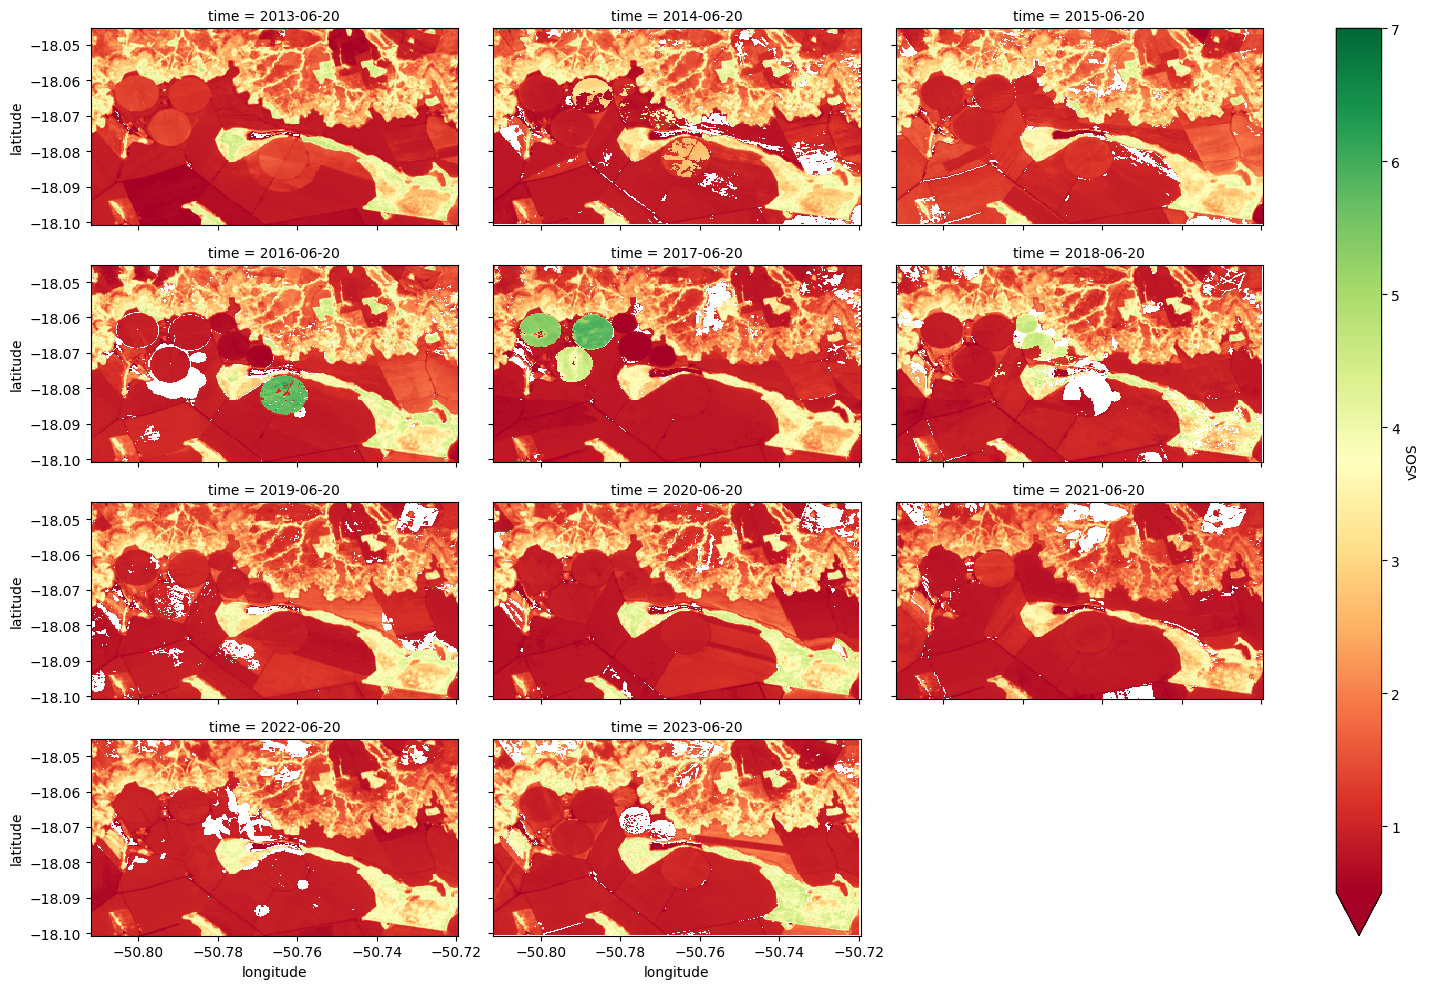

In [28]:
pheno['vSOS'].plot(col = 'time', cmap='RdYlGn', vmin = 0.5, vmax = 7, col_wrap = 3, figsize=(16,10))

### plots
#### interactive

In [31]:
y = 2023
plot_phenology(pheno, y, 'SOS', farm, parcels)

BokehModel(combine_events=True, render_bundle={'docs_json': {'66671faf-330a-474a-a74b-6f3e94ea45e4': {'version…

In [32]:
plot_phenology(pheno, y, 'vSOS', farm, parcels)

BokehModel(combine_events=True, render_bundle={'docs_json': {'7a26e2cc-c908-46cb-b9a4-19a70ecc532c': {'version…

In [33]:
plot_phenology(pheno, y, 'POS', farm, parcels)

BokehModel(combine_events=True, render_bundle={'docs_json': {'29a7c984-6a25-462b-b293-c4e219c3c996': {'version…

In [34]:
plot_phenology(pheno, y, 'vPOS', farm, parcels)

BokehModel(combine_events=True, render_bundle={'docs_json': {'864bc096-2083-4c34-910d-2ee8d21c6049': {'version…

In [35]:
plot_phenology(pheno, y, 'EOS', farm, parcels)

BokehModel(combine_events=True, render_bundle={'docs_json': {'3599af10-1aec-4b5d-a171-6a302cdbe011': {'version…

In [36]:
plot_phenology(pheno, y, 'vEOS', farm, parcels)

BokehModel(combine_events=True, render_bundle={'docs_json': {'2ba30ba9-ba54-4520-aa25-b94369e80ec4': {'version…

In [37]:
plot_phenology(pheno, y, 'LOS', farm, parcels)

BokehModel(combine_events=True, render_bundle={'docs_json': {'d720b40c-6225-4068-b375-40a557d81584': {'version…

In [38]:
plot_phenology(pheno, y, 'AOS', farm, parcels)

BokehModel(combine_events=True, render_bundle={'docs_json': {'9306fd47-54f4-48fc-8486-d1656863bffe': {'version…

In [39]:
plot_phenology(pheno, y, 'Trough', farm, parcels)

BokehModel(combine_events=True, render_bundle={'docs_json': {'29ab2439-7080-4f48-85b9-05463c200747': {'version…

In [40]:
plot_phenology(pheno, y, 'ROG', farm, parcels)

BokehModel(combine_events=True, render_bundle={'docs_json': {'397aa231-6f29-4db1-9d1b-706119480f7c': {'version…

In [41]:
plot_phenology(pheno, y, 'ROS', farm, parcels)

BokehModel(combine_events=True, render_bundle={'docs_json': {'8eefec48-ab1d-43d5-97cf-847518cdfc3f': {'version…

### The matplotlib way

<Axes: title={'center': 'AOS for 2020'}, xlabel='longitude', ylabel='latitude'>

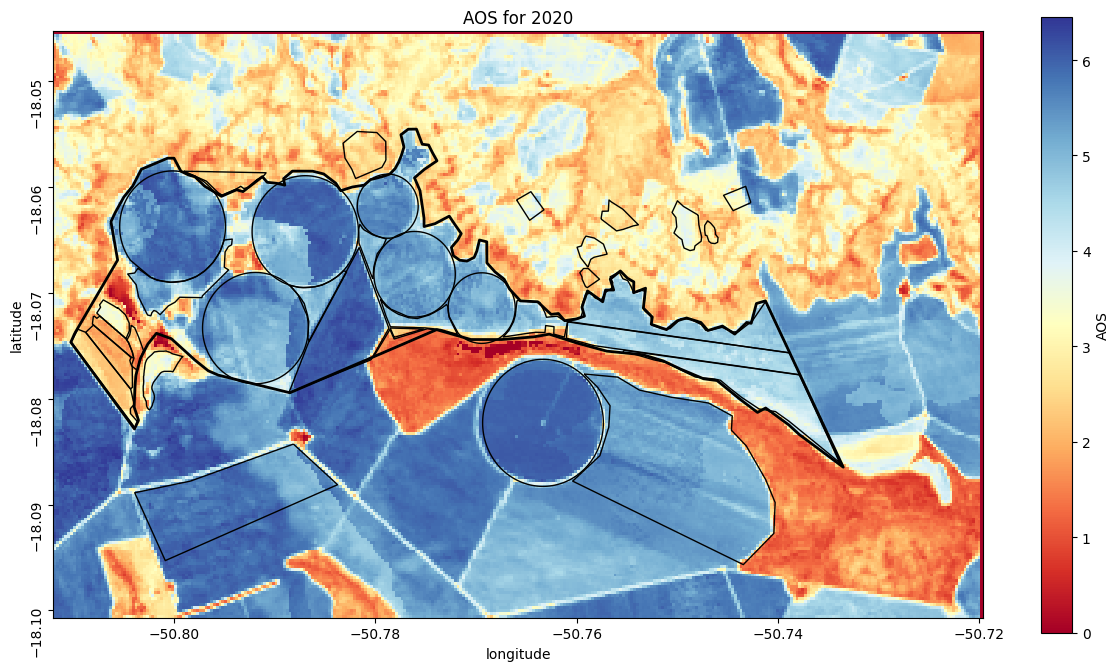

In [42]:
metric = 'AOS'
year = 2020
da = pheno[metric].sel(time=pheno.time.dt.year == int(year)).squeeze()
fig, ax = plt.subplots(figsize=(15,8))
da.plot.pcolormesh(x = 'longitude' , y = 'latitude', ax=ax, cmap='RdYlBu')
plt.title(f'{metric} for {year}')
plt.yticks(rotation=90)
farm.plot(ax=ax, edgecolor='black', lw = 2, color='none')
parcels.plot(ax=ax, edgecolor='black', lw = 1, color='none')

In [61]:
da.shape

(199, 332)

('latitude', 'longitude')

In [102]:
# PLOT Phenology - interactive
def plot_phenology2( pheno, year, metric, farm, parcels = 'None', width = 12):
    '''
        Learn more
        https://docs.xarray.dev/en/stable/generated/xarray.DataArray.plot.pcolormesh.html
    '''

    da = pheno[metric].sel(time=pheno.time.dt.year == int(year)).squeeze()
    h = np.round(da.shape[0]*width/da.shape[1])
    if h > width:
        orientation = 'vertical'
    else:
        orientation = 'horizontal'

    if metric in ['ROG','ROS']:
        qs = da.quantile([0.01,0.99]).values
        cmap = 'PiYG'
        label = 'LAI / day'
        vmin,vmax = qs[0],qs[1]

    if metric in ['vSOS', 'vPOS', 'vEOS', 'AOS', 'Trough']:
        cmap = 'RdYlGn'
        vmin,vmax = 0, 7.5
        label = 'LAI'

    if metric in ['SOS', 'POS', 'EOS', 'LOS']:
        cmap = 'bwr'
        vmin,vmax = 1, 365
        label = 'day of year'          
        
    fig, ax = plt.subplots(figsize=(width,h))
    da.plot.pcolormesh(x = 'longitude' , y = 'latitude', vmin=vmin, vmax=vmax, ax=ax, cmap=cmap,
                       cbar_kwargs={'orientation':orientation,'shrink':0.6, 'aspect':30,'label': label})
    plt.title(f'{metric} for {year}')
    #plt.yticks(rotation=90)
    farm.plot(ax=ax, edgecolor='black', lw = 2, color='none')
    parcels.plot(ax=ax, edgecolor='black', lw = 1, color='none')


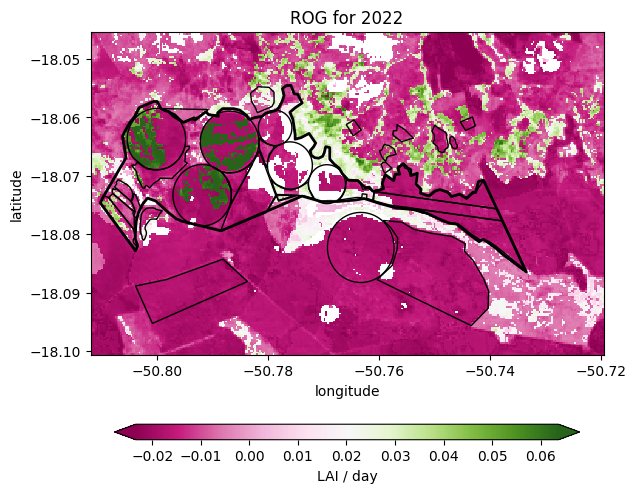

In [103]:
metric = 'ROG'
plot_phenology2(pheno, y, metric, farm, parcels, 10)

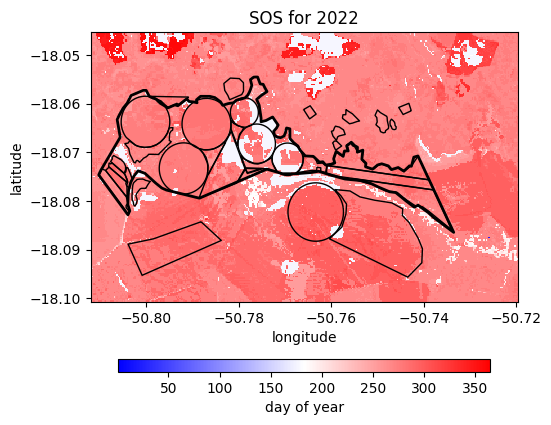

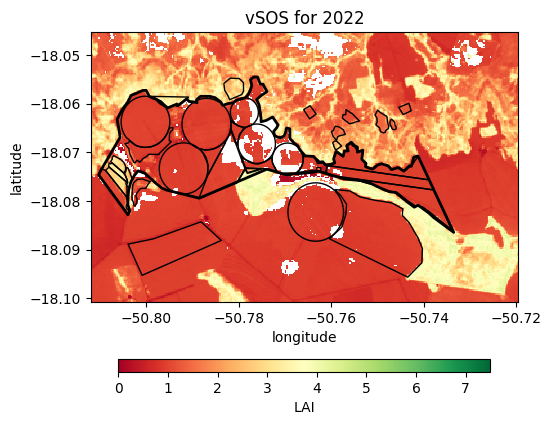

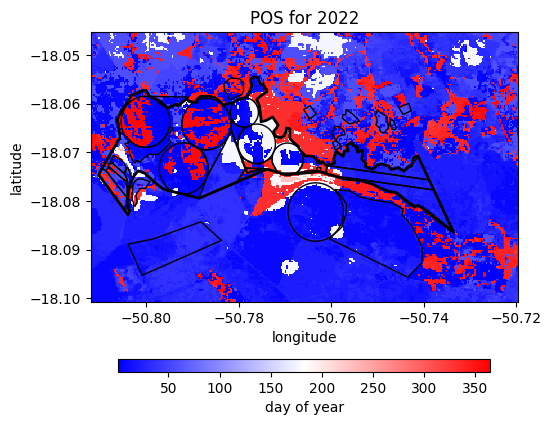

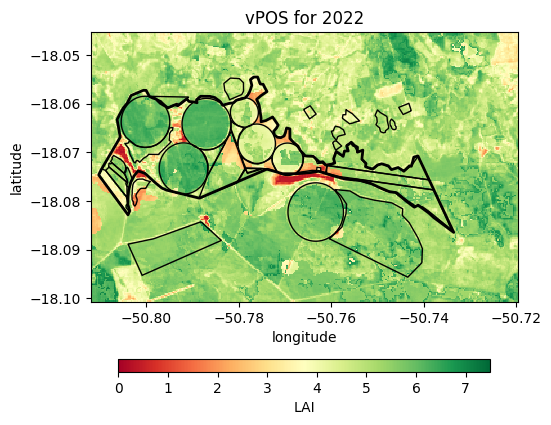

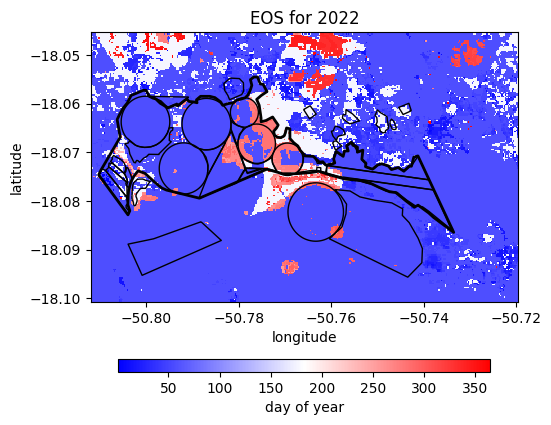

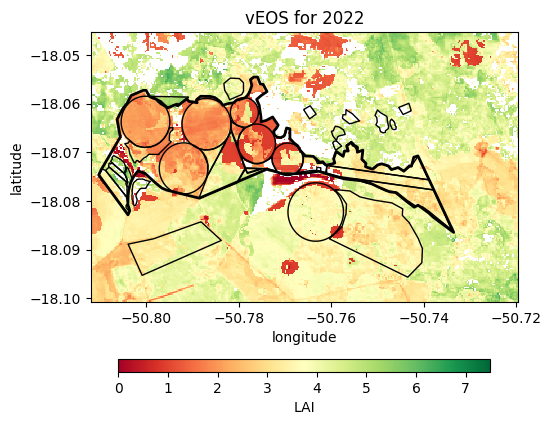

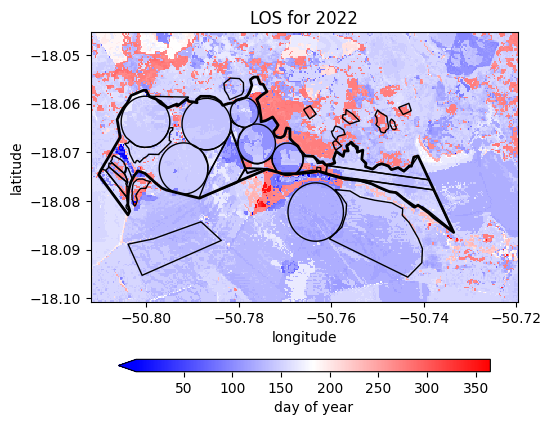

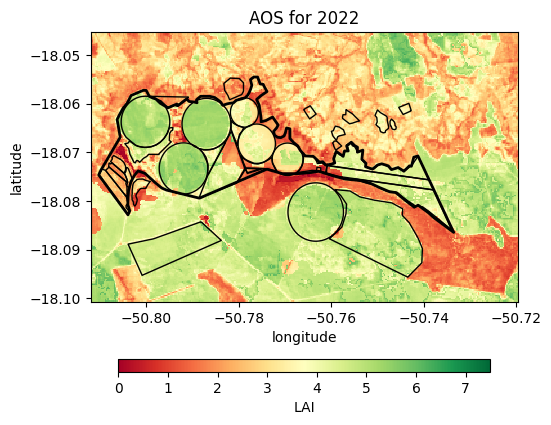

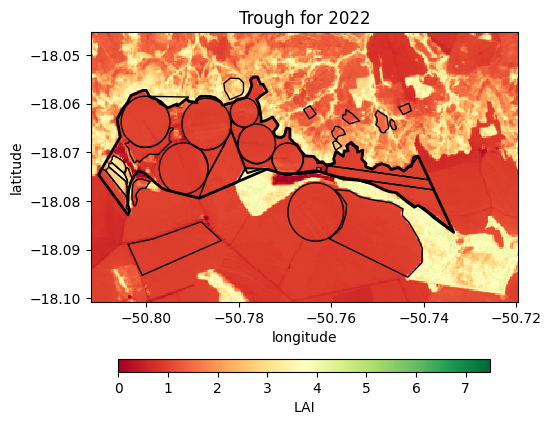

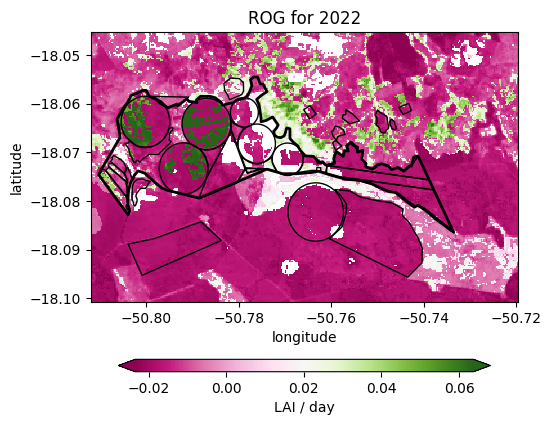

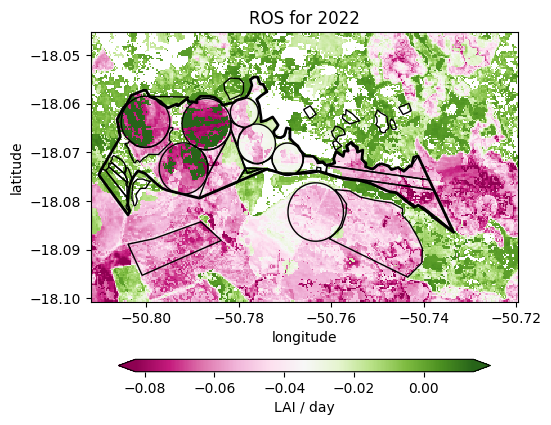

In [104]:
y = 2022
phenos = ['SOS','vSOS','POS','vPOS','EOS','vEOS','LOS','AOS','Trough','ROG','ROS']
for metric in phenos:
    plot_phenology2(pheno, y, metric, farm, parcels, 8)